# Wykorzystane zależności
- [librosa](https://librosa.org/)
- [numpy](https://numpy.org/)
- [sklearn](https://scikit-learn.org/)

In [1]:
import os
import librosa
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_predict


## Załadowanie danych z systemu plików
Załadowanie d danych testowych oraz trenig

In [2]:
DATA_DIR: str = '../../dataset/'

In [3]:
labels: list = []
features: list = []

In [4]:
# --- ZAAWANSOWANA EKSTRAKCJA CECH (84 parametry) ---
# Skład: 
# 1. MFCC (13) x (Mean, Std)
# 2. Delta (13) x (Mean, Std)
# 3. Delta-Delta (13) x (Mean, Std) - Przyspieszenie
# 4. Cechy Spektralne (Centroid, Rolloff, ZCR) x (Mean, Std)

labels = []
features = []

# Ustalona liczba MFCC (standard w audio recognition to 13-20)
N_MFCC = 13 

print(f"Pobieranie danych z: {DATA_DIR}")

for label in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, label)
    
    if not os.path.isdir(class_dir):
        continue
        
    print(f"Przetwarzanie klasy: {label}...")
    
    for filename in os.listdir(class_dir):
        if filename.endswith(".wav"):
            file_path = os.path.join(class_dir, filename)
            
            try:
                # Wczytanie pliku
                y, sr = librosa.load(file_path, sr=None)
                
                # --- 1. MFCC i pochodne (Dynamika) ---
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
                delta = librosa.feature.delta(mfcc)           # Prędkość zmian
                delta2 = librosa.feature.delta(mfcc, order=2) # Przyspieszenie zmian
                
                # --- 2. Cechy Spektralne (Barwa i Szum) ---
                # Centroid: "Jasność" dźwięku
                centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
                # Rolloff: Rozkład częstotliwości
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                # ZCR: Szum vs Ton (kluczowe dla perkusyjnych/szumowych)
                zcr = librosa.feature.zero_crossing_rate(y)
                
                # --- 3. Agregacja (Mean + Std) ---
                # Spłaszczamy czas do statystyk. Wektor wynikowy to jedna długa lista liczb.
                feature_vector = numpy.concatenate([
                    numpy.mean(mfcc, axis=1), numpy.std(mfcc, axis=1),
                    numpy.mean(delta, axis=1), numpy.std(delta, axis=1),
                    numpy.mean(delta2, axis=1), numpy.std(delta2, axis=1),
                    [numpy.mean(centroid), numpy.std(centroid)],
                    [numpy.mean(rolloff), numpy.std(rolloff)],
                    [numpy.mean(zcr), numpy.std(zcr)]
                ])

                features.append(feature_vector)
                labels.append(label)
                
            except Exception as e:
                print(f"Błąd przy pliku {filename}: {e}")

print(f"Zakończono! Wymiar wektora cech: {len(features[0])}")

Pobieranie danych z: ../../dataset/
Przetwarzanie klasy: clapping...
Przetwarzanie klasy: footsteps...
Przetwarzanie klasy: doorbell...


/home/muzykos-laptop/Documents/GIThub/Projekt_badawczy_System_rozpoznawania_zdarzen_dzwiekowych_w_przestrzeni_domowej-main/.venv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Przetwarzanie klasy: vacuum_cleaner...
Przetwarzanie klasy: faucet...
Przetwarzanie klasy: hairdryer...
Przetwarzanie klasy: door_knock...
Zakończono! Wymiar wektora cech: 84


In [5]:
features_xs = numpy.array(features)
labels_ys = numpy.array(labels)

Rozpoczynam walidację krzyżową...
Wyniki CV (5-fold): [0.76595745 0.75268817 0.82795699 0.79569892 0.74193548]
Średnia dokładność (CV): 77.68% (+/- 3.13%)

Dokładność na zbiorze testowym (Hold-out): 83.76%


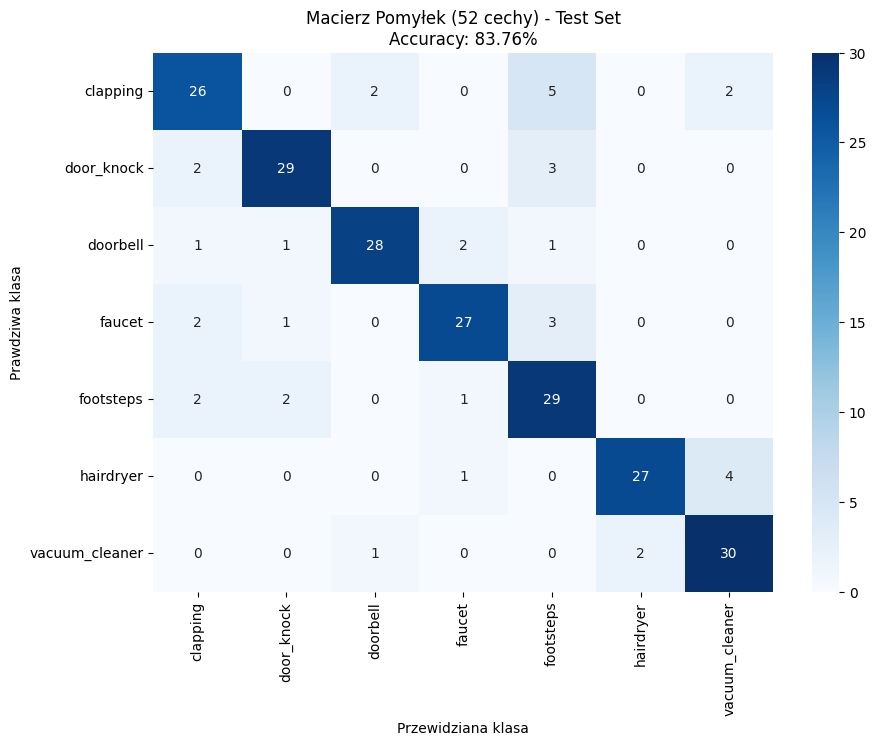

In [6]:
# --- PRZYGOTOWANIE DANYCH I TRENING (PIPELINE) ---

# 1. Encodowanie etykiet (zamiana nazw na liczby)
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(labels_ys)

# 2. Podział na zbiór treningowy i testowy (Stratified zapewnia równe proporcje klas)
x_train, x_test, y_train, y_test = train_test_split(
    features_xs, y_enc, test_size=1/3, random_state=42, stratify=y_enc
)

# 3. Tworzymy Pipeline: Skalowanie + SVM
# Pipeline automatycznie pilnuje, żeby nie było wycieku danych przy walidacji krzyżowej
clf_pipeline = make_pipeline(
    StandardScaler(), 
    SVC(kernel="rbf", C=1.0, probability=True, random_state=42)
)

# 4. Trening i Walidacja Krzyżowa (5-fold) na zbiorze treningowym
print("Rozpoczynam walidację krzyżową...")
cv_scores = cross_val_score(clf_pipeline, x_train, y_train, cv=5, scoring='accuracy')

print(f"Wyniki CV (5-fold): {cv_scores}")
print(f"Średnia dokładność (CV): {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")

# 5. Finalny trening na całym zbiorze treningowym
clf_pipeline.fit(x_train, y_train)

# 6. Sprawdzenie na zbiorze testowym (ostateczna weryfikacja)
y_pred = clf_pipeline.predict(x_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nDokładność na zbiorze testowym (Hold-out): {test_acc:.2%}")

# --- WIZUALIZACJA MACIERZY POMYŁEK ---
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title(f"Macierz Pomyłek (52 cechy) - Test Set\nAccuracy: {test_acc:.2%}")
plt.ylabel("Prawdziwa klasa")
plt.xlabel("Przewidziana klasa")
plt.show()

## Klasyfikator SVM

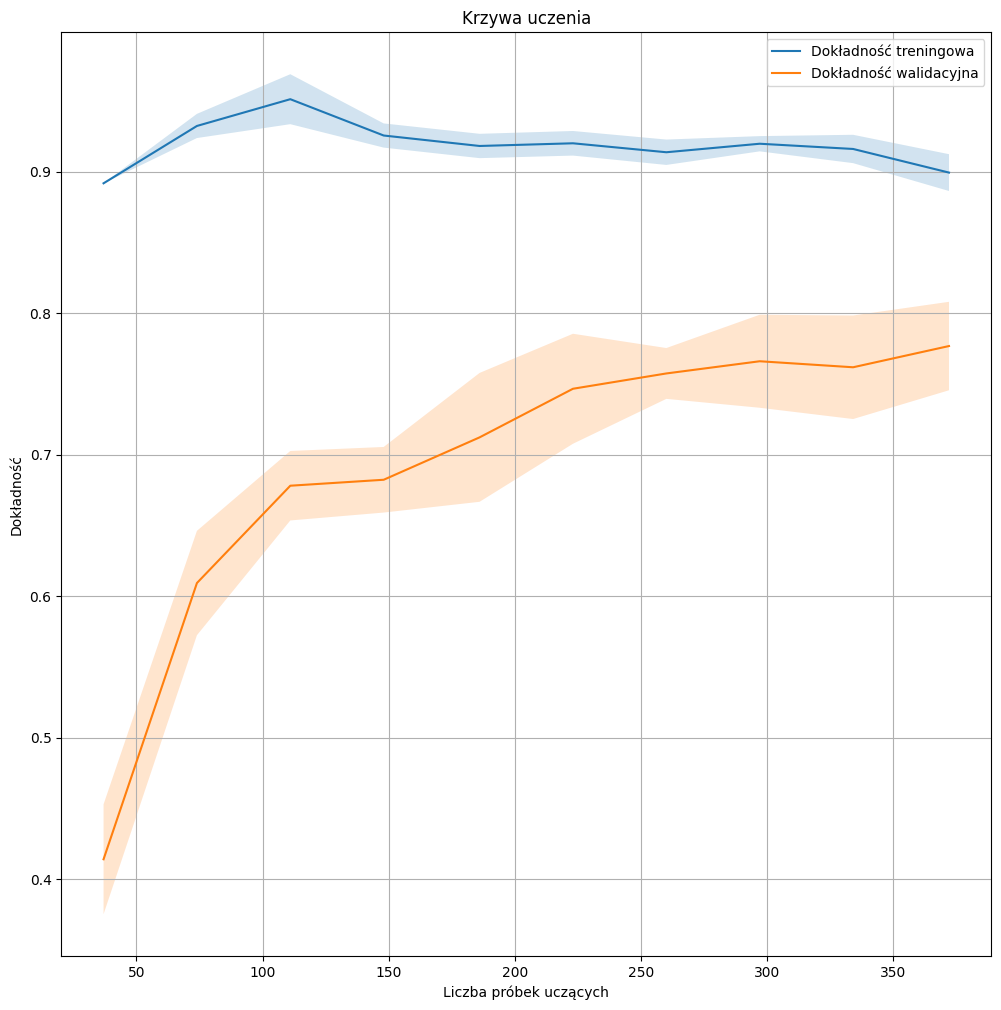

In [7]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=clf_pipeline,
    X=x_train,
    y=y_train,
    cv=5,
    train_sizes=numpy.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = numpy.mean(train_scores, axis=1)
train_std = numpy.std(train_scores, axis=1)
val_mean = numpy.mean(val_scores, axis=1)
val_std = numpy.std(val_scores, axis=1)

plt.figure(figsize=(12, 12))
plt.plot(train_sizes, train_mean, label="Dokładność treningowa")
plt.plot(train_sizes, val_mean, label="Dokładność walidacyjna")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Krzywa uczenia")
plt.xlabel("Liczba próbek uczących")
plt.ylabel("Dokładność")
plt.legend()
plt.grid(True)
plt.show()

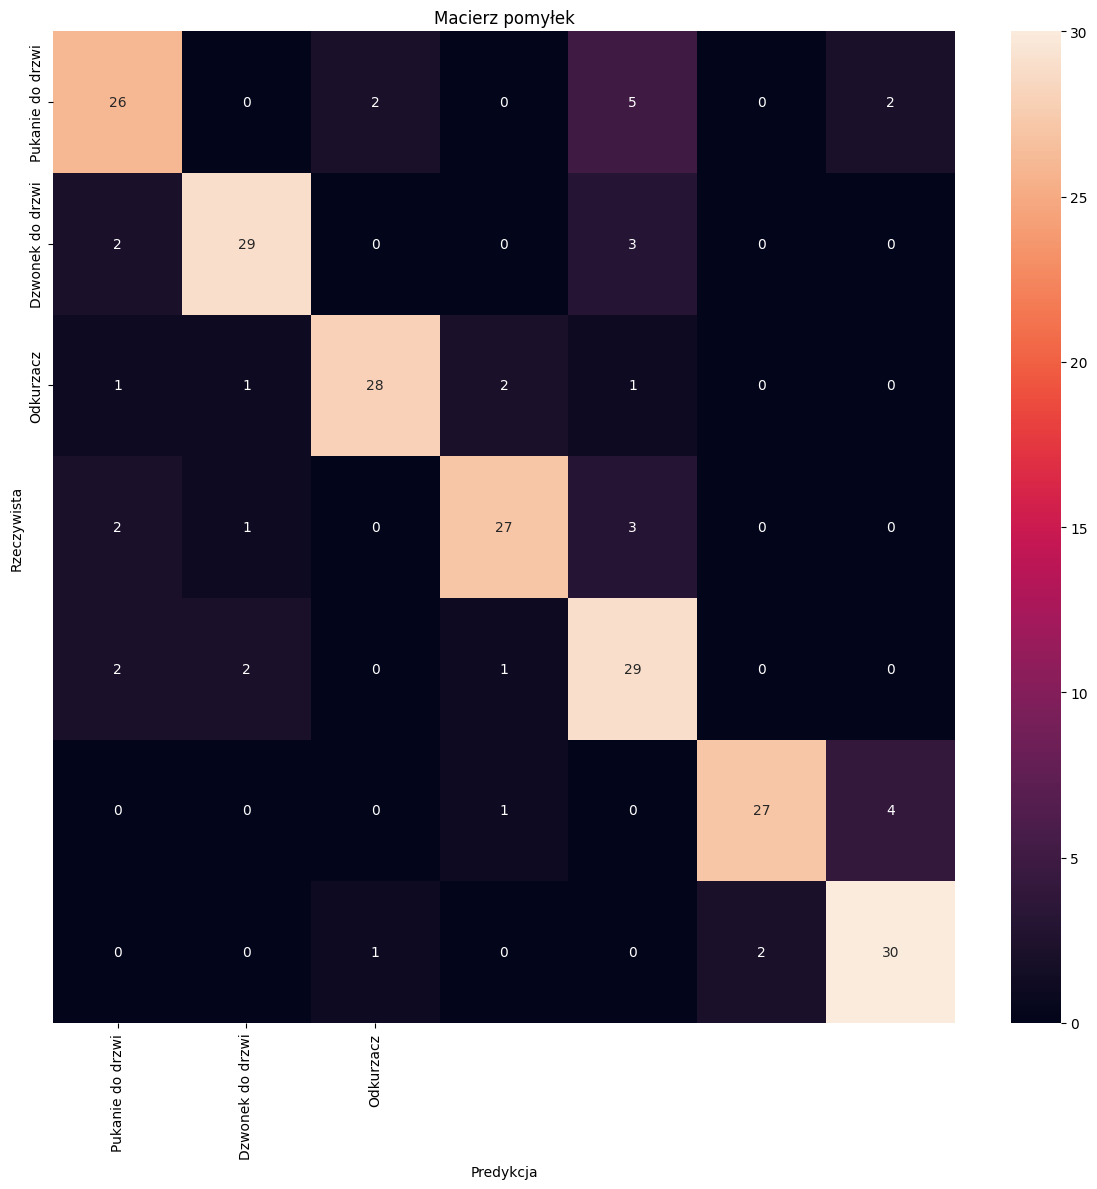

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    xticklabels=["Pukanie do drzwi", "Dzwonek do drzwi", "Odkurzacz"],
    yticklabels=["Pukanie do drzwi", "Dzwonek do drzwi", "Odkurzacz"],
)

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywista")
plt.title("Macierz pomyłek")
plt.tight_layout()
plt.show()

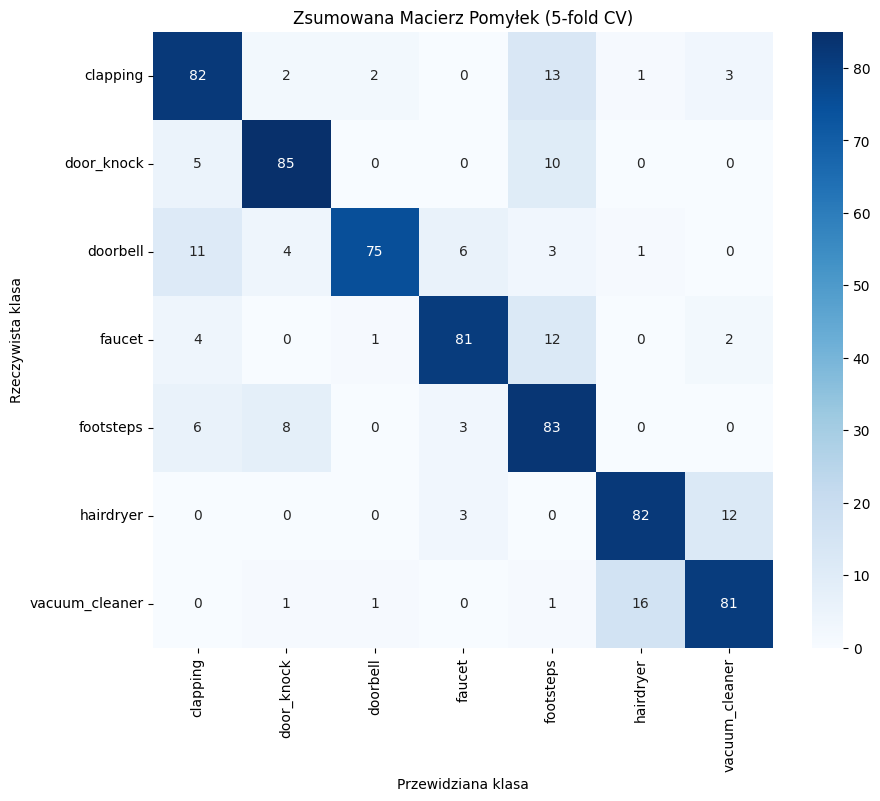

In [9]:
# 1. Definiujemy brakujące zmienne (K-Fold)
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# 2. Generujemy predykcje dla całego zbioru danych przy użyciu CV
# Używamy features_xs i y_enc (cały zbiór), pipeline sam zadba o skalowanie wewnątrz każdego foldu
y_pred_cv = cross_val_predict(clf_pipeline, features_xs, y_enc, cv=skf)

# 3. Wizualizacja Macierzy Pomyłek
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_enc, y_pred_cv)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_, # Pobieramy nazwy klas z encodera
    yticklabels=label_encoder.classes_
)

plt.xlabel("Przewidziana klasa")
plt.ylabel("Rzeczywista klasa")
plt.title(f"Zsumowana Macierz Pomyłek ({k_folds}-fold CV)")
plt.show()